In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import random
import pyepo
import torch
from torch import nn
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135) # fix random seed

Auto-Sklearn cannot be imported.


## Load Data

We use the Warcraft terrains shortest paths [dateset](https://edmond.mpdl.mpg.de/dataset.xhtml?persistentId=doi:10.17617/3.YJCQ5S). Datasets were randomly generated from the Warcraft II [tileset](http://github.com/war2/war2edit) and used in Vlastelica, Marin, et al. "Differentiation of Blackbox Combinatorial Solvers".

In [3]:
# map size
k = 12

### Maps 

In [4]:
tmaps_train = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/train_maps.npy".format(k,k))
tmaps_test = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/test_maps.npy".format(k,k))

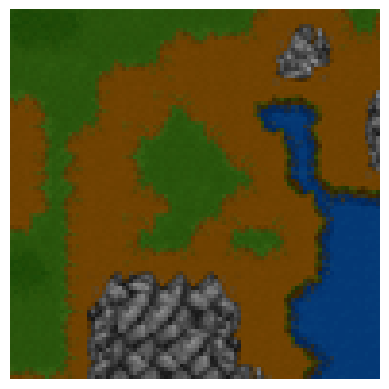

In [5]:
plt.axis("off")
plt.imshow(tmaps_train[0])
plt.show()

### Costs 

In [6]:
costs_train = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/train_vertex_weights.npy".format(k,k))
costs_test = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/test_vertex_weights.npy".format(k,k))

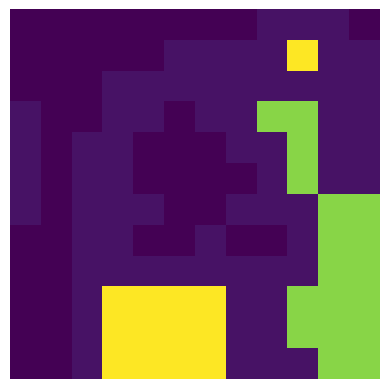

In [7]:
plt.axis("off")
plt.imshow(costs_train[0])
plt.show()

### Paths 

In [8]:
paths_train = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/train_shortest_paths.npy".format(k,k))
paths_test = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/test_shortest_paths.npy".format(k,k))

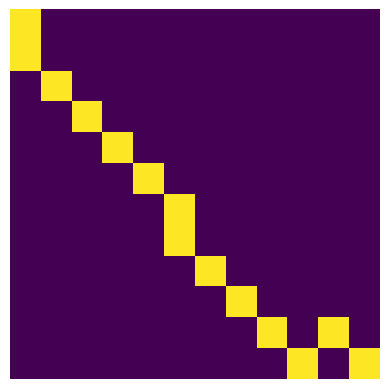

In [9]:
plt.axis("off")
plt.imshow(paths_train[0])
plt.show()

## Data Loader 

In [10]:
from torch.utils.data import Dataset
class mapDataset(Dataset):
    def __init__(self, tmaps, costs, paths):
        self.tmaps = tmaps
        self.costs = costs
        self.paths = paths
        
    def __len__(self):
        return len(self.costs)
    
    def __getitem__(self, ind):
        return (
            torch.FloatTensor(self.tmaps[ind].transpose(2, 0, 1)/255), # image
            torch.FloatTensor(self.costs[ind]),
            torch.FloatTensor(self.paths[ind]),
        )

In [11]:
# datasets
dataset_train = mapDataset(tmaps_train, costs_train, paths_train)
dataset_test = mapDataset(tmaps_test, costs_test, paths_test)

In [12]:
# dataloader
from torch.utils.data import DataLoader
batch_size = 70
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Neural Network: Part of Resnet18 with Max Pooling

In [13]:
from torchvision.models import resnet18
nnet = resnet18(pretrained=False)
print(nnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# build new ResNet18 with Max Pooling
class partialResNet(nn.Module):
    
    def __init__(self, k):
        super(partialResNet, self).__init__()
        # init resnet 18
        resnet = resnet18(pretrained=False)
        # first five layers of ResNet18
        self.conv1 = resnet.conv1
        self.bn = resnet.bn1
        self.relu = resnet.relu
        self.maxpool1 = resnet.maxpool
        self.block = resnet.layer1
        # conv to 1 channel
        self.conv2  = nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
        # max pooling
        self.maxpool2 = nn.AdaptiveMaxPool2d((k,k))
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.bn(h)
        h = self.relu(h)
        h = self.maxpool1(h)
        h = self.block(h)
        h = self.conv2(h)
        out = self.maxpool2(h)
        return torch.squeeze(out, 1)

## Two-Stage 

In [15]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
optimizer = torch.optim.Adam(nnet.parameters(), lr=5e-4)
# number of epochs
epochs = 50

In [16]:
# set loss
mseloss = nn.MSELoss()

In [ ]:
# train
loss_log = []
for epoch in range(epochs):
    for x, c, w in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w = x.cuda(), c.cuda(), w.cuda()
        # forward pass
        cp = nnet(x) # predicted cost
        loss = mseloss(cp, c) # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log.append(loss.item())
    #if epoch % 5 == 0:
        # true regret
        #regret = pyepo.metric.regret(nnet, optmodel, loader_test)
        #regret_log.append(regret)
        #print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))

In [ ]:
# draw plot
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iters", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Learning Curve on Training Set", fontsize=16)
plt.show()